# Join SUNTANS data using dask
See examples:

 - [http://matthewrocklin.com/blog/work/2017/01/17/dask-images](http://matthewrocklin.com/blog/work/2017/01/17/dask-images)

In [1]:
# Use a dask client
from dask.distributed import Client, LocalCluster, worker, progress, wait
import dask
from dask_jobqueue import SLURMCluster


"""
cluster = LocalCluster(
    n_workers=8,
    threads_per_worker=1,
    memory_limit='4GB',
    #memory_spill_fraction=0.1,
    #local_dir='./TMPDATA/'
)
cluster
"""
'''
# Run on zeus
cluster = LocalCluster(
            #"146.118.38.127",
            #'127.0.0.1:37053',
            #workers=8, 
            #ncores=8,
            #threads_per_worker=1, 
            #memory_limit='4GB',
            #local_dir='/home/mrayson/scratch/tmp_dask/',
            #diagnostics_port="8787",
        )
'''



'\n# Run on zeus\ncluster = LocalCluster(\n            #"146.118.38.127",\n            #\'127.0.0.1:37053\',\n            #workers=8, \n            #ncores=8,\n            #threads_per_worker=1, \n            #memory_limit=\'4GB\',\n            #local_dir=\'/home/mrayson/scratch/tmp_dask/\',\n            #diagnostics_port="8787",\n        )\n'

In [2]:
cluster = SLURMCluster()
client=Client(cluster)
cluster.scale(4)
client

<Client: scheduler='tcp://146.118.38.88:46666' processes=0 cores=0>

# Test the scddripted version

# Load some data

Load some unstructured grid data into a Sundask object. Data is written to different files for each processor so dask is used to concatenate back onto the spatial dimension (there is only one for this unstructured data).

The `loadfull()` method is used to load a variable into a dask.array object.

In [3]:
#from soda.dataio.suntans.sunxray import Sundask, Sunxray
#from soda.dataio.suntans.sunpy import Spatial
import xarray as xr
import dask
import glob
from netCDF4 import Dataset
import numpy as np

import matplotlib.pyplot as plt
import pdb
%matplotlib notebook

In [4]:
#from soda.dataio.ugrid.uplot import Plot as UPlot

In [5]:
from soda.dataio.suntans.sunxray import Sundask


In [13]:
#ncfiles = '/scratch/pawsey0106/mrayson/SUNTANS/NWS/SCENARIOS/NWS_2km_hex_data2/NWS_2km_hex_20140201.nc.*'
#ncfiles = '/scratch/pawsey0106/mrayson/SUNTANS/NWS/SCENARIOS/NWS_2km_hex_2013_2014_data9/NWS_2km_hex_20140901.nc.*'
#ncfiles = '../SCENARIOS/NWS_2km_hex_2013_2014_data1/NWS_2km_hex_20130701.*'
ncfiles = '../SCENARIOS/NWS_2km_hex_2013_2014_data3/NWS_2km_hex_20130901.nc.*[0-9]'
#ncfiles = '../SCENARIOS/NWS_2km_hex_2013_2014_data9/NWS_2km_hex_20140301.*'
#ncfiles = '../SCENARIOS/NWS_2km_hex_2013_2014_data11/NWS_2km_hex_20140501.*'



#ncfiles = '/scratch/pawsey0106/mrayson/SUNTANS/NWS/SCENARIOS/NWS_5km_hex_data1/NWS_5km_hex_20130701.nc.*'

#filenames = sorted(glob.glob(ncfiles))
#print(filenames[0:10])
#ds

In [14]:
sun = Sundask(ncfiles)
sun._ds

Time dimension time
converting variable: xp
converting variable: yp


<xarray.Dataset>
Dimensions:       (Nc: 1245, Ne: 3953, Nk: 100, Nkw: 101, Np: 454016, Two: 2, numsides: 8, time: 721)
Coordinates:
    xv            (Nc) float64 dask.array<shape=(1245,), chunksize=(1245,)>
    yv            (Nc) float64 dask.array<shape=(1245,), chunksize=(1245,)>
    xe            (Ne) float64 dask.array<shape=(3953,), chunksize=(3953,)>
    ye            (Ne) float64 dask.array<shape=(3953,), chunksize=(3953,)>
    z_r           (Nk) float64 dask.array<shape=(100,), chunksize=(100,)>
    z_w           (Nkw) float64 dask.array<shape=(101,), chunksize=(101,)>
    Nk            (Nc) int32 dask.array<shape=(1245,), chunksize=(1245,)>
  * time          (time) datetime64[ns] 2013-09-01T00:00:30 ... 2013-10-01
Dimensions without coordinates: Nc, Ne, Nkw, Np, Two, numsides
Data variables:
    suntans_mesh  int32 ...
    cells         (Nc, numsides) int32 dask.array<shape=(1245, 8), chunksize=(1245, 8)>
    face          (Nc, numsides) int32 dask.array<shape=(1245, 8), chun

In [19]:
# Plot vorticity
def calc_vorticity(sun, u, v):
    def _AverageAtFace(phi,jj,k):


        grad1 = sun.grad[:,0]
        grad2 = sun.grad[:,1]
        #Apply mask to jj
        #jj[self.cellmask]=0
        nc1 = grad1[jj]
        nc2 = grad2[jj]

        ind1 = nc1==-1
        nc1[ind1]=nc2[ind1]
        ind2 = nc2==-1
        nc2[ind2]=nc1[ind2]

        # check depths (walls)
        indk = operator.or_(k>=self.Nk[nc1], k>=self.Nk[nc2])
        ind3 = operator.and_(indk, sun.Nk[nc2]>self.Nk[nc1])
        nc1[ind3]=nc2[ind3]
        ind4 = operator.and_(indk, sun.Nk[nc1]>self.Nk[nc2])
        nc2[ind4]=nc1[ind4]

        # Average the values at the face
        return 0.5*(phi[nc1]+phi[nc2])

    # Calculate the edge u and v
    ne = self.face #edge-indices

    ue = _AverageAtFace(u,ne,k)
    ve = _AverageAtFace(v,ne,k)
    ue[self.cellmask]=0
    ve[self.cellmask]=0

    sun.calc_tangent()

    # tx[self.cellmask]=0
    # ty[self.cellmask]=0

    # Now calculate the vorticity
    return np.sum( (ue*sun.tx + ve*sun.ty )*mag,axis=-1)/sun.Ac

In [ ]:
def vorticity(self, u, v):
    """
    Calculate the vertical vorticity component

    Uses gradient method
    """


    sz = u.shape

    if len(sz)==1: # One layer
        du_dx,du_dy = self.gradH(u,k=self.klayer[0])
        dv_dx,dv_dy = self.gradH(v,k=self.klayer[0])

        data = dv_dx - du_dy

    else: # 3D
        data = np.zeros(sz)

        for k in self.klayer:
            du_dx,du_dy = self.gradH(u[:,k],k=k)
            dv_dx,dv_dy = self.gradH(v[:,k],k=k)

            data[:,k] = dv_dx - du_dy

    return data


In [22]:
sun.grad

In [21]:
u_now = sun.get_data('uc', klayer=0, tstep=1)
v_now = sun.get_data('vc', klayer=0, tstep=1)
u_now

dask.array<concatenate, shape=(246528,), dtype=float64, chunksize=(9890,)>

# Test plotting

In [9]:
temp = sun.get_data('temp', klayer=0)
 # Grab all time
temp_mean = temp.mean(axis=0)
temp_mean

dask.array<mean_agg-aggregate, shape=(246528,), dtype=float64, chunksize=(9890,)>

In [10]:
#uplt = uplot.Plot(xp, yp, cells, nfaces=nfaces)
uplt = sun

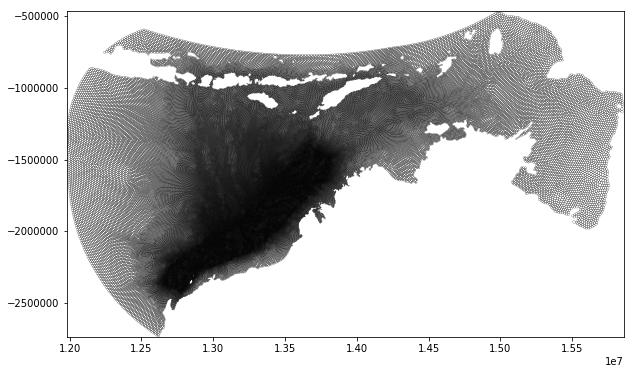

In [11]:
plt.figure(figsize=(10,6))
uplt.plotmesh()
plt.show()

/home/mrayson/anaconda2/envs/soda/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


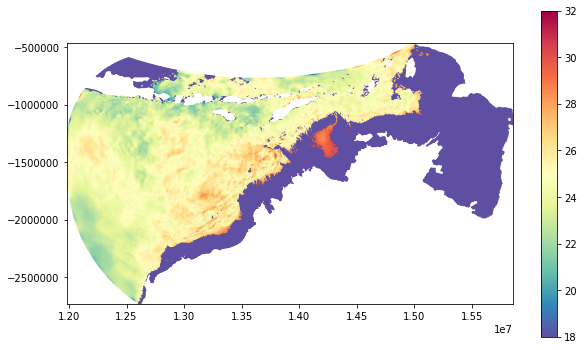

In [15]:
# Plot one time step
temp_now = sun.load_data('temp',tstep=221, klayer=11)
plt.figure(figsize=(10,6))
uplt.plotcelldata(temp_now, cmap='Spectral_r',vmin=18, vmax=32)
plt.show()

In [16]:
# Mean plot
plt.figure(figsize=(10,6))
uplt.plotcelldata(temp_mean[sun.ghost], cmap='Spectral_r',vmin=26, vmax=32)
plt.show()

KeyboardInterrupt: 

KeyboardInterrupt: 

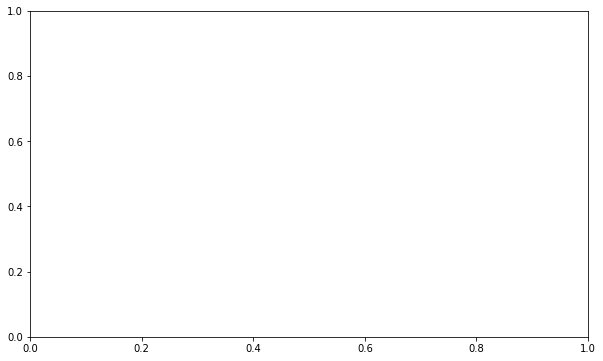

In [17]:
%%time
# Plot the variance
temp_var = temp.var(axis=0)[sun.ghost]
plt.figure(figsize=(10,6))
uplt.plotcelldata(temp_var, cmap='RdBu',vmin=-2, vmax=2)
plt.show()

In [ ]:
%%time
temp100 = sun.stack_var_3d( 'temp', 12).persist()

temp_mean100 = temp100.mean(axis=0)

plt.figure(figsize=(10,6))
uplt.plotcelldata(temp_mean100, cmap='Spectral_r',vmin=18, vmax=27)
plt.show()

In [ ]:
%%time
# Plot the variance
temp_var = temp100.var(axis=0)
plt.figure(figsize=(10,6))
uplt.plotcelldata(temp_var, cmap='RdBu',vmin=-2, vmax=2)
plt.show()

In [ ]:
# Plot the radiation
swrad = sun.stack_var_2d('cloud').mean(axis=0)
lwrad = sun.stack_var_2d('Uwind').mean(axis=0)

plt.figure(figsize=(10,8))
plt.subplot(211)
sun.plotcelldata(swrad)

plt.subplot(212)
sun.plotcelldata(lwrad)

plt.show()

# Testing stuff...

In [ ]:
# Do the same with numpy
from netCDF4 import Dataset
from dask import delayed
import numpy as np

In [ ]:
@delayed
def load_var(ncfile, varname, klayer):
    with Dataset(ncfile) as nc:
        X = nc.variables[varname][:,klayer,:]    
    return X, X.shape

def load_var_np(ncfiles, varname, klayer):
    data = [load_var(ncfile, varname, klayer) for ncfile in ncfiles]
    
    [dask.array.from_delayed(dd, shape=ss, dtype=np.float64) for
         dd, ss in zip(data[0],data[1])]
    
    return data
    
#temp = load_var_np(filenames, varname, klayer)
#allamp = np.concatenate([ii.persist() for ii in temp], axis=-1)
data = [load_var(ncfile, varname, klayer) for ncfile in ncfiles]


In [ ]:
stack = client.persist(temp)
#dir(stack[0])
